In [3]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
# fix random seed for reproducibility
numpy.random.seed(7)


Using TensorFlow backend.


# Import the data

In [4]:
data = pd.read_csv('drive/grouped_data_200.csv')
p = data.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(92897) #Gets 12000 reviews of positive and 8000 negative scores
neg_2000 = neg.sample(57103)
data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
data.dropna(inplace = True) #Drops rows with Nan
data.reset_index(inplace=True) #Replaces missing indexes
data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
data = data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
scores = data['Score']
print("The shape of data is",data.shape)
print("The number of y labels is",len(scores))

The shape of data is (149992, 12)
The number of y labels is 149992


In [5]:
data['Score'].value_counts()

Positive    92894
Negative    57098
Name: Score, dtype: int64

# Perform Train Test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, scores, test_size=0.2)
print("The shape of X_train is",X_train.shape)
print("The shape of X_test is",X_test.shape)
print("The shape of y_train is",y_train.shape)
print("The shape of y_test is",y_test.shape)

The shape of X_train is (119993, 12)
The shape of X_test is (29999, 12)
The shape of y_train is (119993,)
The shape of y_test is (29999,)


# Data Preprocessing

In [8]:
def pos_neg_conv(word): #Function which returns 1 for Positive and 0 for Negative
    return(1 if word=='Positive' else 0)
y_train = list(map(pos_neg_conv,y_train)) #Converts train data from Positive and Negative to 1 and 0
y_test = list(map(pos_neg_conv,y_test))

y_train[:10]

[1, 1, 1, 1, 0, 1, 1, 1, 0, 0]

In [9]:
top_words = 5000 #Gets top 5000 words in frequency of occurance
word_dict = dict(pd.Series(' '.join(X_train.CleanedText).split()).value_counts()[:top_words]) #Create a dictionary of words in decreasing order of frequency of occurance
top_word_list = list(word_dict.keys()) #Gets the list of top words from the dictionary created above
top_word_list[:10]

['like',
 'tast',
 'product',
 'flavor',
 'one',
 'good',
 'use',
 'tri',
 'love',
 'coffe']

**Observations:** Get top 5000 words in its frequency of occurance.

In [0]:
top_word_dict = dict({word:index for word, index in zip(top_word_list, list(range(5000)))}) #Creates a dictionary with word from list of top words and its index for faster lookup

In [11]:
def return_ind(sent): #This function returns a list of indices if words in the review are among the top 5000 words.
    l = sent.split()
    return(list(top_word_dict[a] for a in l if a in top_word_list ))

x_train = []
x_test = []

for train_sent in X_train['CleanedText'].values:
    train_ind = return_ind(train_sent)
    x_train.append(train_ind)

for test_sent in X_test['CleanedText'].values:
    test_ind = return_ind(test_sent)
    x_test.append(test_ind)

print('Length of x_train is',len(x_train))
print('Length of x_test is',len(x_test))

Length of x_train is 119993
Length of x_test is 29999


**Observations:** x_train and x_test are lists which contain indices of words contained in it previously that are also present in the top 5000 words.

# Implement LSTM

In [12]:
max_review_length = 600
x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

print(x_train.shape)
print(x_test.shape)

(119993, 600)
(29999, 600)


In [13]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length,embeddings_regularizer='l2',embeddings_initializer='he_normal'))
model.add(LSTM(100,return_sequences=True,dropout=0.5,kernel_initializer='he_normal'))
model.add(LSTM(100,dropout=0.5,kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 293,701
Trainable params: 293,701
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
model_fit = model.fit(x_train, y_train, nb_epoch=10, batch_size=120, verbose=1, validation_data = (x_test,y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 119993 samples, validate on 29999 samples
Epoch 1/10
119993/119993 [==============================] - 3431s 29ms/step - loss: 0.4641 - acc: 0.8400 - val_loss: 0.4124 - val_acc: 0.8655
Epoch 2/10
119993/119993 [==============================] - 3439s 29ms/step - loss: 0.4264 - acc: 0.8608 - val_loss: 0.4053 - val_acc: 0.8682
Epoch 3/10
119993/119993 [==============================] - 3455s 29ms/step - loss: 0.4190 - acc: 0.8634 - val_loss: 0.4065 - val_acc: 0.8657
Epoch 4/10
119993/119993 [==============================] - 3451s 29ms/step - loss: 0.4161 - acc: 0.8648 - val_loss: 0.4177 - val_acc: 0.8670
Epoch 5/10
119993/119993 [==============================] - 3445s 29ms/step - loss: 0.4213 - acc: 0.8636 - val_loss: 0.4107 - val_acc: 0.8675
Epoch 6/10
119993/119993 [==============================] - 3458s 29ms/step - loss: 0.4146 - acc: 0.8669 - val_loss: 0.4106 - val_acc: 0.8701
Epoch 7/10
119993/119993 [==============================] - 3477s 29ms/step - loss: 0.4111 - acc:

['drive/model_lstm.pkl']

In [16]:
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

29999/29999 [==============================] - 1075s 36ms/step
Accuracy: 87.35%


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4

def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid(linestyle='-')
    fig.canvas.draw()

Test score: 0.39577894278131187
Test accuracy: 0.8734957832007206


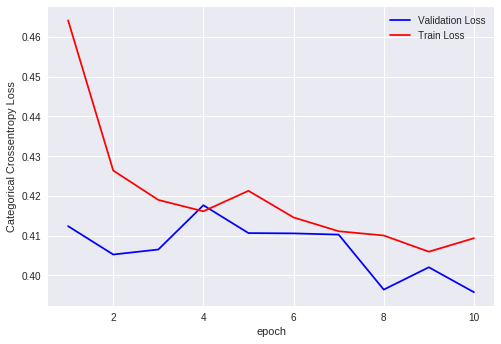

In [18]:
import matplotlib.pyplot as plt
#model_scores = best_model.evaluate(x_test, y_test_cat, verbose=0) 
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,11))

vy = model_fit.history['val_loss']
ty = model_fit.history['loss']

plt_dynamic(x, vy, ty, ax)

# Results:

**1**. The model had a reduced log loss of (0.26 approx) and higher accuracy (92%) when there weren't any dropouts or kernel initializer. But it overfit a lot.

**2**. When dropouts are added along with kernel initializers, a validation log loss of 0.3958 is obtained with an accuracy of 87.35%. This model had no overfitting and showed signs to improve performance over and increase in the number of epochs.